# Predicciones para top 5 por categoría
## En función de ArrDelay

In [ ]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil

import math
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,2009)]

# Funciones necesarias

In [ ]:
def nrmse(pred,y):
    return math.sqrt(mean_squared_error(pred, y)) / (y.max()-y.min())

max_grade = 1
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 

Conseguir top 5

In [ ]:
def get_top(column, yrs):    
    df_acc = pd.DataFrame(columns=["FlightNum", column]).set_index(column)
    for year in yrs:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["FlightNum", column], \
                         encoding="ISO 8859-1")    


        df = df.groupby(by=column).count()
        df_acc = pd.concat([df_acc, df]).groupby(column).sum()
        del df 
    top = df_acc.nlargest(5, 'FlightNum')
    return top

Crear directorio con data de delays agrupada por filter_column 

In [ ]:
def create_grouped_files(subdir, years, subset, filter_column, delay_column="ArrDelay"):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    
    df_cut = pd.DataFrame(columns=["date", filter_column, delay_column])
    df_full = pd.DataFrame(columns=["date", filter_column, delay_column])
    for year in years:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["Month", "Year", "DayofMonth", "DayOfWeek", delay_column, filter_column], \
                         encoding="ISO 8859-1")    

        #solo los del valor pedido
        df = df.loc[df[filter_column].isin(subset)]

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
        df["date"] = dates

        #acumulamos en full antes de recortar outliers
        df = df[["date", delay_column, filter_column]]
        dg = df.groupby(
                [pd.Grouper(key='date', freq='M'), pd.Grouper(key=filter_column)] 
            ).mean().reset_index()

        df_full = pd.concat([df_full, dg], sort=False)
        
        #sacamos outliers
        low = 0.1
        high = 0.9

        group = [pd.Grouper(key='date', freq='M'), pd.Grouper(key=filter_column)]
        df = df.groupby(group) \
                .apply(lambda x : 
                  x[(x[delay_column] >= x[delay_column].quantile(low)) & 
                    (x[delay_column] <= x[delay_column].quantile(high))]
              .mean()
              ).reset_index()
        
        if (year==1994):
            print(df)
        
        df_cut = pd.concat([df_cut, df], sort=False)
        del df 

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

Plotear datos

In [78]:
def plot_df(df1, df2, train_limit_axis, unit_str, delay_column="ArrDelay"):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))
    
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay', legend=True)
    df2[delay_column].plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1, legend=True)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

#max_grade = 0    
#Validación cruzada y gráficos
#devuelve array de nrmse
def cross_val_delays(subdir, filter_column, entity, n=4, delay_column="ArrDelay"):
    #for trim in ["full", "cut"]:
    #al final anda mejor full
    trim = "full"
    
    print("\n\n------Trim de outliers: {}------------------------------------".format(trim))

    df = pd.read_csv(tmp_dir+"{}/{}.csv".format(subdir, trim))
    df = df[df[filter_column] == entity]
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.sort_values(by="date")

    tscv = TimeSeriesSplit(n_splits=n)
    df_full = pd.read_csv(tmp_dir+"{}/full.csv".format(subdir))
    df_full = df_full[df_full[filter_column] == entity]
    df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')

    #si recortamos alguna fecha por outliers la sacamos de df_full tambien para comparar
    if trim == "cut":
        df_full = df_full.loc[df_full["date"].isin(df.date)]

    errors = []
    for train_index, test_index in tscv.split(df):
        delays_train, delays_test = df.iloc[train_index][delay_column], df.iloc[test_index][delay_column]
        lpr = lsqPredictor(phases, monthly_freqs, max_grade)
        lpr.fit(delays_train)
        #lpr.print_coefs()
        train_test_delays = df[delay_column]

        df2 = df
        day_train_limit = df2.iloc[len(delays_train)]["date"]

        print("Entrena hasta la fecha: {}".format(day_train_limit))
        df2["dl_pred"] = lpr.pred(train_test_delays) 
        plot_df(df2.reset_index(), df_full.reset_index(), len(delays_train), "mes", delay_column)

        error = nrmse(
            df2.loc[df["date"].dt.date > day_train_limit].dl_pred, 
            df_full.loc[df_full["date"].dt.date > day_train_limit][delay_column]
        )

        print("Error:{} \n\n".format(error))
        errors.append(error)
    del df
    del df2
    del df_full
    avg_error = np.average(errors)
    print("Error promedio de {}:{} \n\n".format(entity, avg_error))
    return errors
    
def get_error_and_plot_top(top_rank, entity_name, subdir, filter_column, delay_column="ArrDelay"):
    errors = []
    for entity in top_rank:
        print("{}: {}".format(entity_name.capitalize(), entity))
        errors += cross_val_delays(subdir, filter_column, entity, n=4, delay_column=delay_column)
    print("Error promedio para top 5 {}: {}".format(entity_name, np.average(errors)))
    return errors

cat_error = pd.DataFrame(columns=["category", "error"])

## Top 5 aerolíneas

In [ ]:
#conseguimos el top
years = [str(year) for year in range(1994,2000)]
df = get_top("UniqueCarrier", years)

if not os.path.exists(tmp_dir+"carriers/"):
    os.makedirs(tmp_dir+"carriers/")
        
df.to_csv(top_carriers.csv")
df

In [ ]:
df.to_csv(tmp_dir+"carriers/top_carriers.csv")

In [79]:
df = pd.read_csv(tmp_dir+"carriers/top_carriers.csv")

In [80]:
top_carriers = df.reset_index()["UniqueCarrier"]
top_carriers

0    DL
1    US
2    WN
3    UA
4    AA
Name: UniqueCarrier, dtype: object

In [ ]:
#filtramos los vuelos del top
years = [str(year) for year in range(1994, 2009)]
create_grouped_files("carriers/", years, top_carriers, "UniqueCarrier")

In [ ]:
max_grade = 1
#graficamos y calculamos errores
carrier_errors = get_error_and_plot_top(top_carriers, "Carrier", "carriers/", "UniqueCarrier")
for err in carrier_errors:
    cat_error = cat_error.append({"category":"Carrier", "error":err}, ignore_index=True)

## Top 5 aeropuertos

In [ ]:
#conseguimos el top
years = [str(year) for year in range(1994,2000)]

df = get_top("Origin", years)

if not os.path.exists(tmp_dir+"airports/"):
    os.makedirs(tmp_dir+"airports/")
                    
df.to_csv(tmp_dir+"airports/top_airports.csv")
df

In [82]:
df = pd.read_csv(tmp_dir+"airports/top_airports.csv")
top_airports = df.reset_index()["Origin"]
top_airports

0    ORD
1    DFW
2    ATL
3    LAX
4    STL
Name: Origin, dtype: object

#### Conseguir sus vuelos

In [ ]:
years = [str(year) for year in range(1994,2009)]
create_grouped_files("airports/", years, top_airports, "Origin")

In [ ]:
max_grade = 1

#graficamos y calculamos errores
airport_errors = get_error_and_plot_top(top_airports, "Airport", "airports/", "Origin")
for err in airport_errors:
    cat_error = cat_error.append({"category":"Airport", "error":err}, ignore_index=True)

## Top 5 rutas
### Funciones necesarias

In [ ]:
def get_top_routes(yrs):    
    df_acc = pd.DataFrame(columns=["FlightNum", "origin_city", "dest_city"]).set_index(["origin_city", "dest_city"])
    df_cities = pd.read_csv("../data/airports.csv", usecols=["city", "iata"])
    origin_df = df_cities.rename(columns={"city": "origin_city", "iata": "origin_iata"})  
    dest_df = df_cities.rename(columns={"city": "dest_city", "iata": "dest_iata"})  
    
    for year in yrs:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["FlightNum", "Origin", "Dest"], \
                         encoding="ISO 8859-1")    
        
        #agrego las ciudades
        df = df.merge(origin_df, left_on='Origin', right_on='origin_iata')
        df = df.merge(dest_df, left_on='Dest', right_on='dest_iata')
        
        #ciudades que mas aparecen
        df = df.groupby(["origin_city", "dest_city"]).count()
        df_acc = pd.concat([df_acc, df], join="inner").groupby(["origin_city", "dest_city"]).sum()
        del df 
    top = df_acc.nlargest(5, 'FlightNum')
    return top

In [ ]:
#conseguimos vuelos del top de pares de ciudades
#como ahora agrupamos por tuplas de ciudades no podemos reusar el create_cities_grouped (sin romperlo antes)
#las funciones que siguen hace lo mismo que venimos haciendo pero para pares de ciudades
def create_cities_grouped_files(subdir, years, delay_column="ArrDelay"):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    
    df_cut = pd.DataFrame(columns=["date", "dest_city", "origin_city", delay_column])
    df_full = pd.DataFrame(columns=["date", "dest_city", "origin_city", delay_column])
    
    df_cities = pd.read_csv("../data/airports.csv", usecols=["city", "iata"])
    origin_df = df_cities.rename(columns={"city": "origin_city", "iata": "origin_iata"})  
    dest_df = df_cities.rename(columns={"city": "dest_city", "iata": "dest_iata"})  
    
    routes = top_routes.reset_index()
    routes = routes[["origin_city", "dest_city"]]
    
    for year in years:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["Month", "Year", "DayofMonth", "DayOfWeek", delay_column, "Origin", "Dest"], \
                         encoding="ISO 8859-1")    

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
        df["date"] = dates
        df = df[["date", delay_column, "Origin", "Dest"]]

        #agrego las ciudades
        df = df.merge(origin_df, left_on='Origin', right_on='origin_iata')
        df = df.merge(dest_df, left_on='Dest', right_on='dest_iata')
        df = df[["date", delay_column, "origin_city", "dest_city"]]
        
        #solo los del valor pedido
        df = df.merge(routes, how="inner")
        #acumulamos en full antes de recortar outliers
        dg = df.groupby(
                [pd.Grouper(key='date', freq='M'), pd.Grouper(key="origin_city"),  pd.Grouper(key="dest_city")] 
            ).mean().reset_index()
        
        df_full = pd.concat([df_full, dg], join="outer" , sort=False)
        
        #sacamos outliers
        low = 0.1
        high = 0.9

        group = [pd.Grouper(key='date', freq='M'), pd.Grouper(key="origin_city"),  pd.Grouper(key="dest_city")]
        df = df.groupby(group) \
                .apply(lambda x : 
                  x[(x[delay_column] >= x[delay_column].quantile(low)) & 
                    (x[delay_column] <= x[delay_column].quantile(high))]
              .mean()
              ).reset_index()
        
        if (year==1994):
            print(df)
    
        df_cut = pd.concat([df_cut, df], join="outer" , sort=False)
        del df 

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

In [ ]:
max_grade = 0    

#graficamos el top de pares de ciudades
def get_error_and_plot_top_cities(top_rank, subdir, delay_column="ArrDelay"):
    top_errors = []
    avg_errors = []
    for [src_city, dest_city] in top_rank:
        print("Cities: {}->{}".format(src_city, dest_city))

        df_full = pd.read_csv(tmp_dir+subdir+"/full.csv")
        df_full = df_full[(df_full.origin_city == src_city) & (df_full.dest_city == dest_city)]
        df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
        
        #for trim in ["cut", "full"]:
        trim = "full"
        print("Trim: {}".format(trim))
        df = pd.read_csv("{}{}/{}.csv".format(tmp_dir, subdir, trim))
        df = df[(df.origin_city == src_city) & (df.dest_city == dest_city)]
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df.sort_values(by="date")

        tscv = TimeSeriesSplit(n_splits=4)

        #si recortamos alguna fecha por outliers la sacamos de df_full tambien para comparar
        if trim == "cut":
            df_full = df_full.loc[df_full["date"].isin(df.date)]

        errors = []
        for train_index, test_index in tscv.split(df):
            delays_train, delays_test = df.iloc[train_index][delay_column], df.iloc[test_index][delay_column]
            lpr = lsqPredictor(phases, monthly_freqs, max_grade)
            lpr.fit(delays_train)
            #lpr.print_coefs()
            train_test_delays = df[delay_column]

            df2 = df
            day_train_limit = df2.iloc[len(delays_train)]["date"]

            print("Entrena hasta la fecha: {}".format(day_train_limit))
            df2["dl_pred"] = lpr.pred(train_test_delays) 
            plot_df(df2.reset_index(), df_full.reset_index(), len(delays_train), "mes", delay_column)

            error = nrmse(
                df2.loc[df["date"].dt.date > day_train_limit].dl_pred, 
                df_full.loc[df_full["date"].dt.date > day_train_limit][delay_column]
            )

            print("Error:{} \n\n".format(error))
            errors.append(error)
            del df2
        
        top_errors += errors
        avg_errors.append(np.average(errors))
        print("Error promedio de {}->{}: {} \n\n".format(src_city, dest_city, np.average(errors)))
        del df
        del df_full
    print("Error promedio en gral. de pares de ciudades: {} \n\n".format(np.average(avg_errors)))
    return top_errors

## Procesar datos

In [ ]:
#conseguimos el top
years = [str(y) for y in range(1994, 2000)]
top_routes = get_top_routes(years)

if not os.path.exists(tmp_dir+"cities/"):
    os.makedirs(tmp_dir+"cities/")

top_routes.to_csv(tmp_dir+"cities/top_cities.csv")

In [84]:
top_routes = pd.read_csv(tmp_dir+"cities/top_cities.csv")
top_routes.reset_index()
print(top_routes)

     origin_city      dest_city  FlightNum
0    Los Angeles  San Francisco     100857
1  San Francisco    Los Angeles     100583
2        Chicago    Minneapolis     100098
3    Minneapolis        Chicago      99963
4    Los Angeles      Las Vegas      96728


In [ ]:
years = [str(y) for y in range(1994, 2009)]
create_cities_grouped_files("cities/", years)

In [ ]:
max_grade = 1
routes = top_routes.reset_index()[["origin_city", "dest_city"]].values

#graficamos y calculamos errores
airport_errors = get_error_and_plot_top_cities(routes, "cities/")
for err in airport_errors:
    cat_error = cat_error.append({"category":"Cities", "error":err}, ignore_index=True)

## Comparativo

In [86]:
cat_error 

,category,error
0,Carrier,0.988051
1,Carrier,0.184201
2,Carrier,0.252663
3,Carrier,0.276330
4,Carrier,0.362155
5,Carrier,0.281155
6,Carrier,0.228687
7,Carrier,0.261931
8,Carrier,0.615366
9,Carrier,0.349492


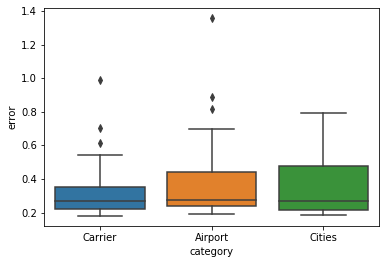

In [87]:
ax = sns.boxplot(x="category", y="error", data=cat_error)

# Predicciones para top 5 por categoría
## Ahora en función de DepDelay

In [ ]:
cat_error_dep = pd.DataFrame(columns=["category", "error"])
tmp_dir = "./tmp_csv/"

## Top 5 aerolíneas

In [ ]:
if not os.path.exists(tmp_dir+"carriers_depdelay/"):
    os.makedirs(tmp_dir+"carriers_depdelay/")

In [ ]:
df = pd.read_csv(tmp_dir+"carriers/top_carriers.csv")

In [ ]:
top_carriers = df.reset_index()["UniqueCarrier"]
top_carriers

In [ ]:
#filtramos los vuelos del top
years = [str(year) for year in range(1994, 2009)]
create_grouped_files("carriers_depdelay/", years, top_carriers, "UniqueCarrier", "DepDelay")

In [ ]:
max_grade = 1
#graficamos y calculamos errores
carrier_errors = get_error_and_plot_top(top_carriers, "Carrier", "carriers_depdelay/", "UniqueCarrier", "DepDelay")
for err in carrier_errors:
    cat_error_dep = cat_error_dep.append({"category":"Carrier", "error":err}, ignore_index=True)

## Top 5 aeropuertos

In [ ]:
if not os.path.exists(tmp_dir+"airports_depdelay/"):
    os.makedirs(tmp_dir+"airports_depdelay/")

In [ ]:
df = pd.read_csv(tmp_dir+"airports/top_airports.csv")
top_airports = df.reset_index()["Origin"]
top_airports

#### Conseguir sus vuelos

In [ ]:
years = [str(year) for year in range(1994,2009)]
create_grouped_files("airports_depdelay/", years, top_airports, "Origin", "DepDelay")

In [ ]:
max_grade = 1

#graficamos y calculamos errores
airport_errors = get_error_and_plot_top(top_airports, "Airport", "airports_depdelay/", "Origin", "DepDelay")
for err in airport_errors:
    cat_error_dep = cat_error_dep.append({"category":"Airport", "error":err}, ignore_index=True)

## Top 5 pares de ciudades

In [ ]:
if not os.path.exists(tmp_dir+"cities_delay/"):
    os.makedirs(tmp_dir+"cities_delay/")

In [ ]:
top_routes = pd.read_csv(tmp_dir+"cities/top_cities.csv")
top_routes.reset_index()
print(top_routes)

In [ ]:
years = [str(y) for y in range(1994, 2009)]
create_cities_grouped_files("cities_delay/", years, "DepDelay")

In [ ]:
max_grade = 1
routes = top_routes.reset_index()[["origin_city", "dest_city"]].values

#graficamos y calculamos errores
airport_errors = get_error_and_plot_top_cities(routes, "cities_delay/", "DepDelay")
for err in airport_errors:
    cat_error_dep = cat_error_dep.append({"category":"Cities", "error":err}, ignore_index=True)

## Comparativo

In [ ]:
cat_error_dep

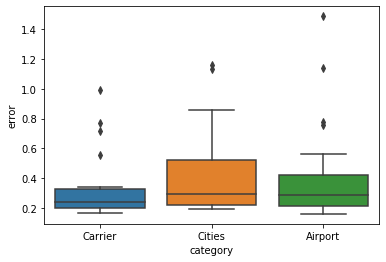

In [71]:
ax = sns.boxplot(x="category", y="error", data=cat_error_dep)